### data merge

In [4]:
import pandas as pd
import glob
import os
import re

# -------- STEP 1: Read all CSV files recursively --------
csv_files = glob.glob("**/*.csv", recursive=True)

raw_dataframes = {}
for file in csv_files:
    try:
        df = pd.read_csv(file)
        raw_dataframes[file] = df
    except Exception as e:
        print(f"Error reading {file}: {e}")

print("Loaded CSV files:")
for k in raw_dataframes.keys():
    print(" -", k)
    

# -------- STEP 2: Clean filenames into Python variable names --------
def clean_name(path):
    """
    Convert path like 
    'data warehouse/Monthly Delay Data.csv'
    into 
    'df_monthly_delay_data'
    """
    base = os.path.basename(path)                    # Monthly Delay Data.csv
    no_ext = os.path.splitext(base)[0]               # Monthly Delay Data
    clean = re.sub(r'[^A-Za-z0-9]+', '_', no_ext)    # Monthly_Delay_Data
    return "df_" + clean.lower()                     # df_monthly_delay_data

# Create clean dictionary
dataframes = {}

for path, df in raw_dataframes.items():
    var_name = clean_name(path)
    dataframes[var_name] = df
    globals()[var_name] = df   # create real Python variable


# -------- STEP 3: Print assigned variable names --------
print("\nAssigned variable names:")
for name in dataframes.keys():
    print(" -", name)


Loaded CSV files:
 - Monthly Fuel Price Data.csv
 - Dim State Data.csv
 - Dim Date Data Warehouse.csv
 - Dim Event Type.csv
 - Passenger Monthly Data.csv
 - Monthly Weather Data.csv
 - Monthly Delay Data.csv
 - Monthly Route Data.csv
 - Airport State Data.csv
 - Monthly Weather Event Data.csv

Assigned variable names:
 - df_monthly_fuel_price_data
 - df_dim_state_data
 - df_dim_date_data_warehouse
 - df_dim_event_type
 - df_passenger_monthly_data
 - df_monthly_weather_data
 - df_monthly_delay_data
 - df_monthly_route_data
 - df_airport_state_data
 - df_monthly_weather_event_data


In [9]:
# Fix the monthly route dataset
df_route = df_monthly_route_data.rename(columns={"origin": "airport"})

# Remove columns that would conflict
df_route = df_route.drop(columns=["year", "month"])

df = df.merge(
    df_route,
    on=["airport", "date_id"],
    how="left"
)
for name, df in dataframes.items():
    print("\n====", name, "====")
    print(df.columns)



==== df_monthly_fuel_price_data ====
Index(['date_id', 'price'], dtype='object')

==== df_dim_state_data ====
Index(['state_id', 'state_abbr'], dtype='object')

==== df_dim_date_data_warehouse ====
Index(['date_id', 'year', 'month'], dtype='object')

==== df_dim_event_type ====
Index(['event_type_id', 'event_type_clean'], dtype='object')

==== df_passenger_monthly_data ====
Index(['year', 'month', 'date_id', 'airport', 'pax_out', 'pax_in', 'pax'], dtype='object')

==== df_monthly_weather_data ====
Index(['state_abbr', 'date_id', 'events', 'severe_events', 'total_damage',
       'wx_index'],
      dtype='object')

==== df_monthly_delay_data ====
Index(['year', 'month', 'carrier', 'airport', 'arr_flights', 'arr_del15',
       'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
       'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
       'date_id'],
      dtype='object')

==

In [104]:
# ----------------------------
# 1. Start with monthly delay data
# ----------------------------
df = df_monthly_delay_data.copy()

# ----------------------------
# 2. Join Date Dimension
# ----------------------------
df = df.merge(
    df_dim_date_data_warehouse,
    on=["date_id", "year", "month"],
    how="left"
)

# ----------------------------
# 3. Join Airport → State
# ----------------------------
df = df.merge(
    df_airport_state_data,       # contains airport + state_abbr
    on="airport",
    how="left"
)

# ----------------------------
# 4. Join State Dimension
# ----------------------------
df = df.merge(
    df_dim_state_data,           # contains state_id, state_abbr
    on="state_abbr",
    how="left"
)

# ----------------------------
# 5. Join Weather (state + date)
# ----------------------------
df = df.merge(
    df_monthly_weather_data,
    on=["state_abbr", "date_id"],
    how="left"
)

# ----------------------------
# 6. Join Monthly Weather Event Data
# ----------------------------
df = df.merge(
    df_monthly_weather_event_data,
    on=["state_abbr", "date_id"],
    how="left"
)

# ----------------------------
# 7. Join Passenger Volume (airport + date)
# ----------------------------
df = df.merge(
    df_passenger_monthly_data,
    on=["airport", "date_id"],
    how="left",
    suffixes=("", "_pax")
)

# ----------------------------
# 8. Join Fuel Prices (date)
# ----------------------------
df = df.merge(
    df_monthly_fuel_price_data,
    on="date_id",
    how="left"
)

print("Unified dataset shape:", df.shape)
df


Unified dataset shape: (53783, 34)


,year,month,carrier,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,...,total_damage,wx_index,event_type_clean,event_count,year_pax,month_pax,pax_out,pax_in,pax,price
0,2025,7,AA,ABQ,292.0,115.0,34.13,2.50,9.33,0.00,...,NaN,NaN,NaN,NaN,2025.0,7.0,35065.0,35179.0,70244.0,2.244
1,2025,7,AA,ALB,121.0,52.0,12.97,2.74,7.85,0.00,...,NaN,NaN,NaN,NaN,2025.0,7.0,17109.0,17327.0,34436.0,2.244
2,2025,7,AA,AMA,29.0,17.0,5.50,0.08,0.81,0.00,...,NaN,NaN,NaN,NaN,2025.0,7.0,3365.0,2567.0,5932.0,2.244
3,2025,7,AA,ANC,93.0,37.0,17.77,1.95,11.66,0.00,...,NaN,NaN,NaN,NaN,2025.0,7.0,17370.0,16665.0,34035.0,2.244
4,2025,7,AA,ATL,717.0,290.0,90.61,13.39,60.02,0.21,...,NaN,NaN,NaN,NaN,2025.0,7.0,88616.0,94236.0,182852.0,2.244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53778,2020,1,AA,XNA,57.0,13.0,5.16,0.00,0.71,0.00,...,7716000.0,31.123914,HEAVY RAIN,1.0,2020.0,1.0,5485.0,5715.0,11200.0,1.770
53779,2020,1,AA,XNA,57.0,13.0,5.16,0.00,0.71,0.00,...,7716000.0,31.123914,ICE STORM,14.0,2020.0,1.0,5485.0,5715.0,11200.0,1.770
53780,2020,1,AA,XNA,57.0,13.0,5.16,0.00,0.71,0.00,...,7716000.0,31.123914,THUNDERSTORM WIND,54.0,2020.0,1.0,5485.0,5715.0,11200.0,1.770
53781,2020,1,AA,XNA,57.0,13.0,5.16,0.00,0.71,0.00,...,7716000.0,31.123914,TORNADO,12.0,2020.0,1.0,5485.0,5715.0,11200.0,1.770


Key drivers:
Weather → weather_delay, events, wx_index  
Fuel Price → price  
Passenger Volume → pax, pax_in, pax_out  
Route Characteristics → distance  
Internal Operations → carrier_delay, nas_delay, etc.


In [90]:

# Define conceptual driver groups
driver_groups = {
    "Weather": ["weather_delay", "weather_ct", "events", "wx_index"],
    "Fuel Price": ["price"],
    "Passenger Volume": ["pax", "pax_in", "pax_out"],
    "Route Characteristics": ["distance"],
    "Internal Operations": [
        "carrier_delay",
        "nas_delay",
        "security_delay",
        "late_aircraft_delay",
        "arr_cancelled",
        "arr_diverted",
        "arr_del15",
        "arr_flights",
    ]
}

# Keep only columns that actually exist
available_drivers = {
    group: [col for col in cols if col in df.columns]
    for group, cols in driver_groups.items()
}

available_drivers



{'Weather': ['weather_delay', 'weather_ct', 'events', 'wx_index'],
 'Fuel Price': ['price'],
 'Passenger Volume': ['pax', 'pax_in', 'pax_out'],
 'Route Characteristics': [],
 'Internal Operations': ['carrier_delay',
  'nas_delay',
  'security_delay',
  'late_aircraft_delay',
  'arr_cancelled',
  'arr_diverted',
  'arr_del15',
  'arr_flights']}

In [98]:
corr_series = df_key.corr()["arr_del15"]

# If it's a DataFrame, squeeze it into a Series
if isinstance(corr_series, pd.DataFrame):
    corr_series = corr_series.iloc[:, 0]

corr = corr_series.drop("arr_del15").sort_values(ascending=False)
corr

corr

carrier_delay          0.982954
late_aircraft_delay    0.972221
pax_out                0.957668
pax                    0.957576
pax_in                 0.957400
arr_flights            0.944796
weather_ct             0.930394
nas_delay              0.922126
weather_delay          0.887332
arr_diverted           0.801703
security_delay         0.752126
arr_cancelled          0.457284
events                 0.183116
wx_index               0.147814
price                  0.081586
Name: arr_del15, dtype: float64

In [99]:
df["delay_rate"] = df["arr_del15"] / df["arr_flights"]
df["carrier_delay_rate"] = df["carrier_delay"] / df["arr_flights"]
df["weather_delay_rate"] = df["weather_delay"] / df["arr_flights"]
df["nas_delay_rate"] = df["nas_delay"] / df["arr_flights"]
df["security_delay_rate"] = df["security_delay"] / df["arr_flights"]
df["late_aircraft_delay_rate"] = df["late_aircraft_delay"] / df["arr_flights"]

df["pax_density"] = df["pax"] / df["arr_flights"]

# Now recompute correlation
features = [
    "carrier_delay_rate",
    "weather_delay_rate",
    "nas_delay_rate",
    "security_delay_rate",
    "late_aircraft_delay_rate",
    "pax_density",
    "events",
    "wx_index",
    "price"
]

corr = df[["delay_rate"] + features].corr()["delay_rate"].sort_values(ascending=False)
corr


delay_rate                  1.000000
late_aircraft_delay_rate    0.742584
carrier_delay_rate          0.659885
nas_delay_rate              0.508889
price                       0.381506
pax_density                 0.269814
weather_delay_rate          0.262506
events                      0.200430
wx_index                    0.168062
security_delay_rate         0.089719
Name: delay_rate, dtype: float64

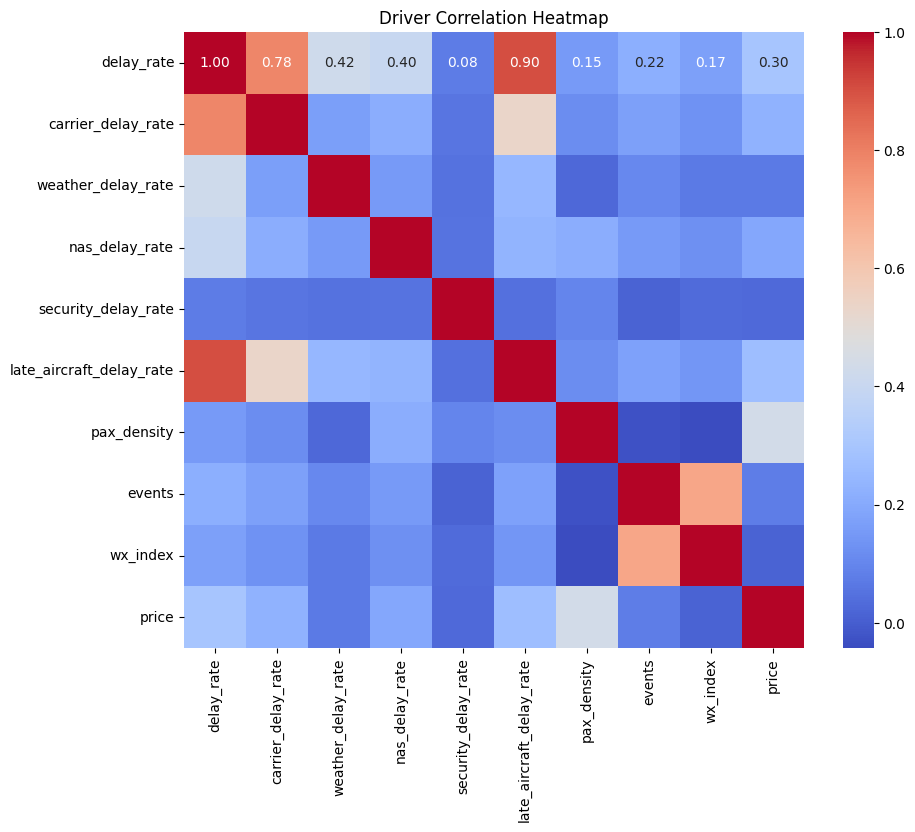

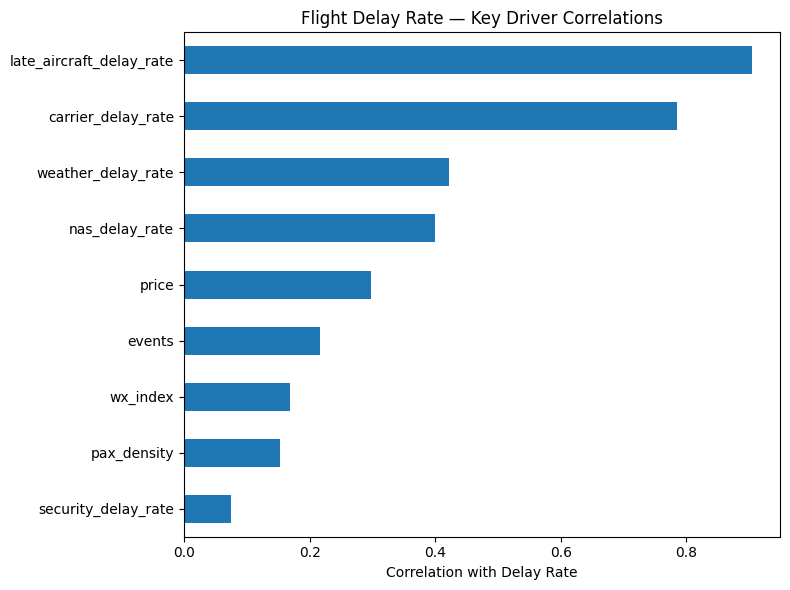

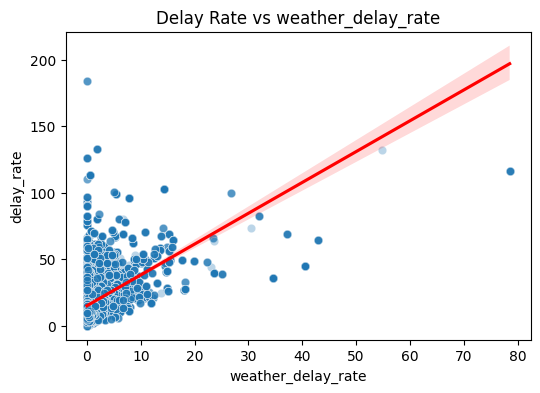

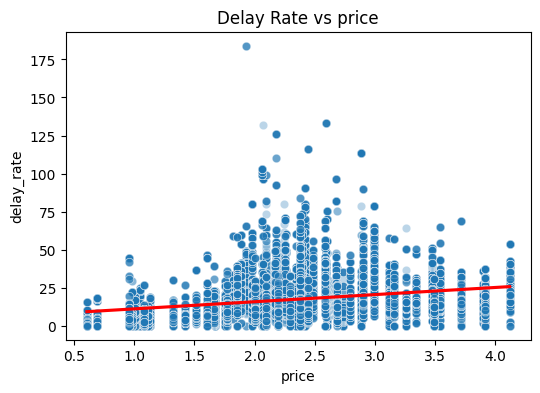

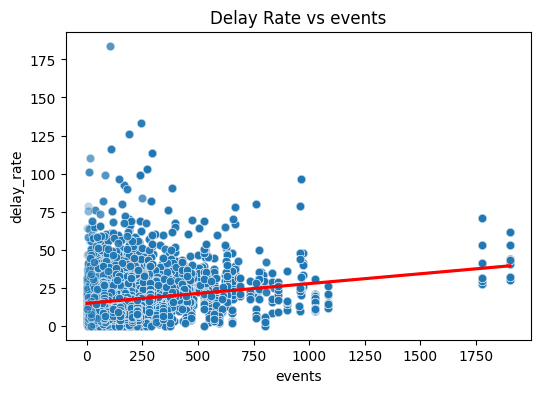

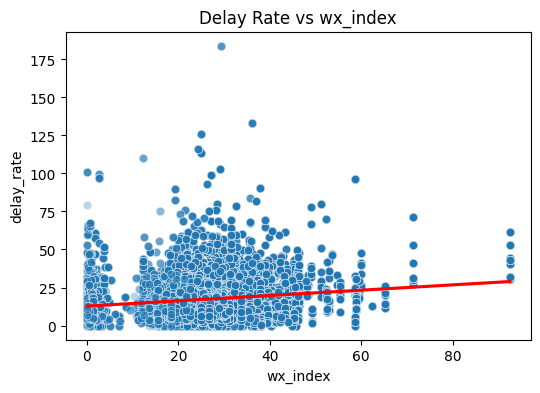

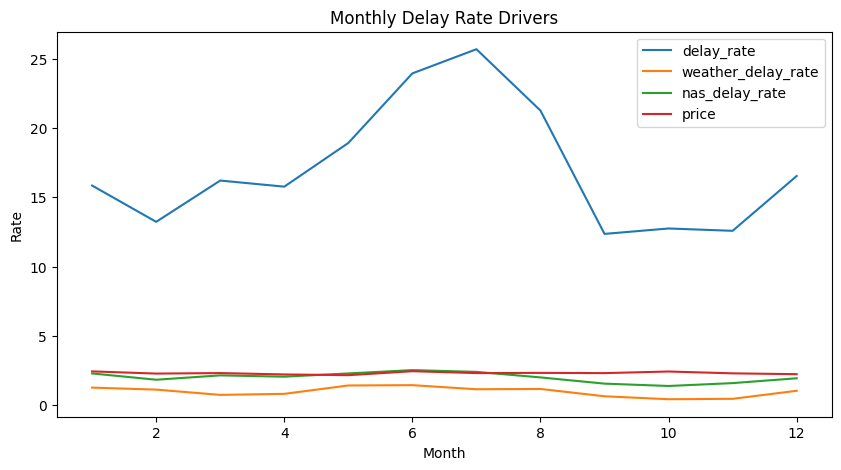

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------
# 1. Correlation Heatmap
# ---------------------------------------
plt.figure(figsize=(10, 8))
corr_matrix = df[["delay_rate"] + features].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Driver Correlation Heatmap")
plt.show()

# ---------------------------------------
# 2. Bar Chart of Key Drivers
# ---------------------------------------
plt.figure(figsize=(8, 6))

corr.iloc[1:].sort_values().plot(kind="barh")   # Skip "delay_rate"

plt.title("Flight Delay Rate — Key Driver Correlations")
plt.xlabel("Correlation with Delay Rate")
plt.tight_layout()
plt.show()

# ---------------------------------------
# 3. Scatterplots for External Drivers
# ---------------------------------------
external = ["weather_delay_rate", "price", "events", "wx_index"]

for col in external:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[col], y=df["delay_rate"], alpha=0.3)
    sns.regplot(x=df[col], y=df["delay_rate"], scatter=False, color="red")
    plt.title(f"Delay Rate vs {col}")
    plt.show()

# ---------------------------------------
# 4. Monthly Trends
# ---------------------------------------
monthly = df.groupby("month")[["delay_rate", "weather_delay_rate",
                               "nas_delay_rate", "price"]].mean()

plt.figure(figsize=(10, 5))
for col in monthly.columns:
    plt.plot(monthly.index, monthly[col], label=col)
plt.legend()
plt.title("Monthly Delay Rate Drivers")
plt.xlabel("Month")
plt.ylabel("Rate")
plt.show()


### data profiling

In [ ]:
# Dataset Overview
df.info()
df.head()
df.tail()
df.sample(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53783 entries, 0 to 53782
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      53783 non-null  int64  
 1   month                     53783 non-null  int64  
 2   carrier                   53783 non-null  object 
 3   airport                   53783 non-null  object 
 4   arr_flights               53778 non-null  float64
 5   arr_del15                 53754 non-null  float64
 6   carrier_ct                53778 non-null  float64
 7   weather_ct                53778 non-null  float64
 8   nas_ct                    53778 non-null  float64
 9   security_ct               53778 non-null  float64
 10  late_aircraft_ct          53778 non-null  float64
 11  arr_cancelled             53778 non-null  float64
 12  arr_diverted              53778 non-null  float64
 13  arr_delay                 53778 non-null  float64
 14  carrie

,year,month,carrier,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,...,pax,price,total_delay_time,delay_rate,carrier_delay_rate,weather_delay_rate,nas_delay_rate,security_delay_rate,late_aircraft_delay_rate,pax_density
29803,2022,9,AA,SDF,113.0,28.0,14.63,0.91,2.01,0.00,...,26968.0,3.262,3220.0,28.495575,19.415929,0.433628,0.690265,0.000000,7.955752,238.654867
17434,2023,10,AA,OGG,93.0,9.0,2.45,0.00,3.59,0.00,...,30670.0,2.881,459.0,4.935484,0.913978,0.000000,0.967742,0.000000,3.053763,329.784946
11380,2024,5,AA,MRY,57.0,28.0,14.21,1.78,4.83,0.00,...,10657.0,2.380,2170.0,38.070175,17.789474,2.421053,7.157895,0.000000,10.701754,186.964912
15714,2023,12,AA,EWR,523.0,123.0,31.34,1.29,44.57,1.43,...,168131.0,2.387,7327.0,14.009560,5.376673,0.151052,3.063098,0.057361,5.361377,321.474187
45086,2021,1,AA,GUC,8.0,0.0,0.00,0.00,0.00,0.00,...,1301.0,1.420,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,162.625000


In [ ]:
# Missing Values
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
pd.concat([missing, missing_pct], axis=1, keys=["missing_count", "missing_pct"])


,missing_count,missing_pct
event_count,524,0.974286
event_type_clean,524,0.974286
events,524,0.974286
severe_events,524,0.974286
total_damage,524,0.974286
wx_index,524,0.974286
pax_density,29,0.053920
arr_del15,29,0.053920
year_pax,24,0.044624
month_pax,24,0.044624


In [41]:
df.describe().T  # numeric


,count,mean,std,min,25%,50%,75%,max
year,53783.0,2.022398e+03,1.553010e+00,2020.000000,2021.000000,2022.000000,2.024000e+03,2.025000e+03
month,53783.0,6.145975e+00,3.404096e+00,1.000000,3.000000,6.000000,9.000000e+00,1.200000e+01
arr_flights,53778.0,6.912827e+02,1.759745e+03,1.000000,86.000000,199.000000,5.140000e+02,1.520100e+04
arr_del15,53754.0,1.469431e+02,3.813900e+02,0.000000,18.000000,44.000000,1.120000e+02,5.115000e+03
carrier_ct,53778.0,4.641764e+01,1.024729e+02,0.000000,7.020000,16.790000,4.128000e+01,1.355870e+03
weather_ct,53778.0,5.960700e+00,1.974796e+01,0.000000,0.100000,1.440000,4.460000e+00,3.433800e+02
nas_ct,53778.0,3.842500e+01,1.081684e+02,0.000000,2.860000,7.980000,2.427000e+01,1.685740e+03
security_ct,53778.0,5.335451e-01,1.434898e+00,0.000000,0.000000,0.000000,3.900000e-01,2.044000e+01
late_aircraft_ct,53778.0,5.554063e+01,1.600431e+02,0.000000,5.030000,15.860000,4.282000e+01,2.588130e+03
arr_cancelled,53778.0,1.779453e+01,9.222452e+01,0.000000,0.000000,2.000000,9.000000e+00,2.945000e+03


In [141]:
df.describe(include="object").T  # categorical

,count,unique,top,freq
carrier,53783,1,AA,53783
airport,53783,140,PSP,869
state_abbr,53783,50,CA,10796
event_type_clean,53259,45,THUNDERSTORM WIND,4758


In [156]:
key_drivers = [
    "late_aircraft_delay",
    "carrier_delay",
    "weather_delay",
    "nas_delay",
    "price",
    "events",
    "wx_index",
    "pax",
    "security_delay",
    "arr_delay"
]

num_df = df[key_drivers]

# IQR method
Q1 = num_df.quantile(0.25)
Q3 = num_df.quantile(0.75)
IQR = Q3 - Q1

outlier_mask = (num_df < (Q1 - 1.5 * IQR)) | (num_df > (Q3 + 1.5 * IQR))

# Calculate outlier rate per column
outlier_rate = (outlier_mask.sum() / len(num_df)).sort_values(ascending=False)

# Convert to DataFrame
outlier_df = outlier_rate.to_frame("outlier_rate")
outlier_df



,outlier_rate
security_delay,0.148095
nas_delay,0.141587
wx_index,0.125523
arr_delay,0.119666
late_aircraft_delay,0.114274
carrier_delay,0.113772
weather_delay,0.111225
pax,0.106762
events,0.075916
price,0.000000


In [150]:
# Filter only key-driver columns
missing = df[key_drivers].isna().sum().sort_values(ascending=False)
missing_pct = (df[key_drivers].isna().mean() * 100).sort_values(ascending=False)

missing_summary = pd.concat(
    [missing, missing_pct],
    axis=1,
    keys=["missing_count", "missing_pct"]
)

missing_summary


,missing_count,missing_pct
events,524,0.974286
wx_index,524,0.974286
pax,24,0.044624
late_aircraft_delay,5,0.009297
carrier_delay,5,0.009297
weather_delay,5,0.009297
nas_delay,5,0.009297
security_delay,5,0.009297
arr_delay,5,0.009297
price,0,0.000000


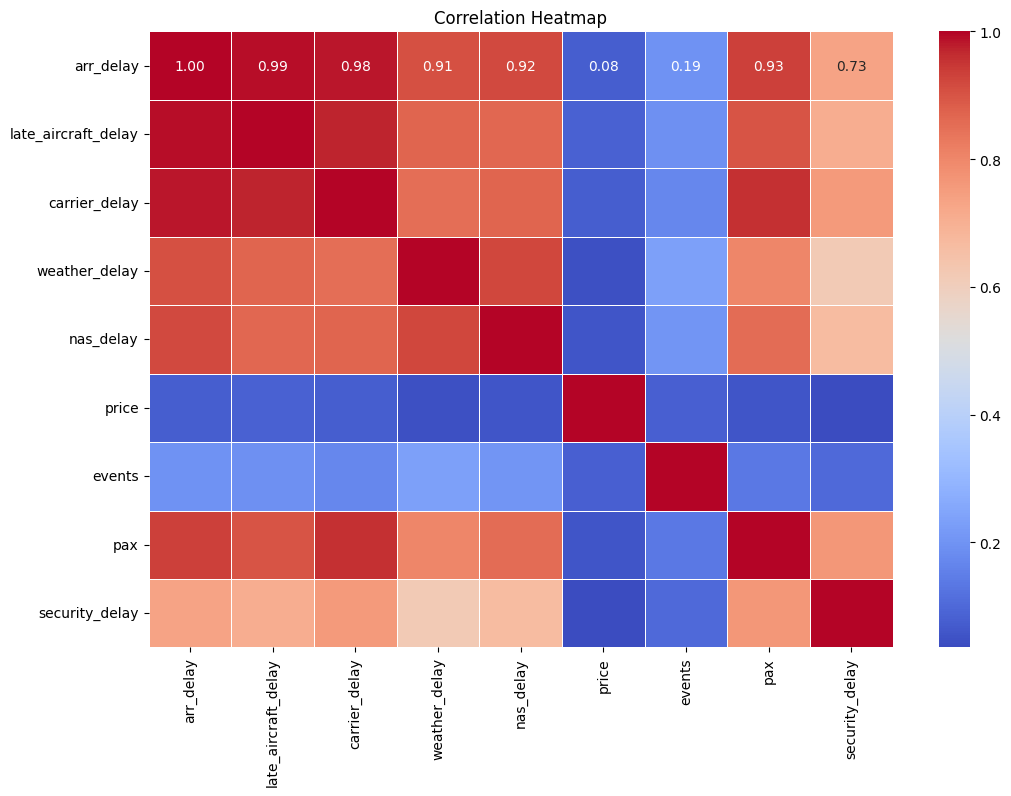

In [155]:
key_drivers_ordered = ["arr_delay"] + [c for c in key_drivers if c != "arr_delay"]

plt.figure(figsize=(12, 8))

# Recompute correlation using reordered list
corr = df[key_drivers_ordered].corr()

sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)

plt.title("Correlation Heatmap")
plt.show()


In [44]:
df.duplicated().sum()


0

### time series

In [49]:
df.columns


Index(['year', 'month', 'carrier', 'airport', 'arr_flights', 'arr_del15',
       'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
       'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
       'date_id', 'state_abbr', 'state_id', 'events', 'severe_events',
       'total_damage', 'wx_index', 'event_type_clean', 'event_count',
       'year_pax', 'month_pax', 'pax_out', 'pax_in', 'pax', 'price',
       'total_delay_time', 'delay_rate', 'carrier_delay_rate',
       'weather_delay_rate', 'nas_delay_rate', 'security_delay_rate',
       'late_aircraft_delay_rate', 'pax_density', 'date'],
      dtype='object')

In [75]:
monthly = (
    df.groupby('date')['arr_del15']
      .sum()
      .reset_index()
)


In [76]:
drivers = (
    df.groupby('date')[[
        'carrier_delay',
        'weather_delay',
        'nas_delay',
        'security_delay',
        'late_aircraft_delay',
        'pax',
        'wx_index',
        'events',
        'price'
    ]].mean().reset_index()
)


In [77]:
ts = monthly.merge(drivers, on='date')


In [78]:
ts[['wx_index','events','pax']].isna().sum()


wx_index    2
events      2
pax         0
dtype: int64

In [79]:
ts[ts[['wx_index','events']].isna().any(axis=1)]


,date,arr_del15,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,pax,wx_index,events,price
65,2025-06-01,27213.0,5674.626984,1529.500,2960.84127,16.52381,8952.079365,190199.952381,NaN,NaN,2.094
66,2025-07-01,29516.0,6910.432000,1450.288,3020.87200,17.90400,10914.896000,197823.840000,NaN,NaN,2.244


In [80]:
import numpy as np

# Replace infinite values first (safety)
ts = ts.replace([np.inf, -np.inf], np.nan)

# Interpolate weather index
ts['wx_index'] = ts['wx_index'].interpolate(method='linear')

# Fill missing event counts with zero
ts['events'] = ts['events'].fillna(0)


In [81]:
ts[['wx_index','events','pax']].isna().sum()


wx_index    0
events      0
pax         0
dtype: int64

In [100]:
driver_cols = [c for c in drivers.columns if c != 'date']
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    ts['arr_del15'],
    exog=ts[driver_cols],
    order=(1,1,1),
    seasonal_order=(1,1,1,12)
)

results = model.fit()
print(results.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46511D+00    |proj g|=  9.61865D-02

At iterate    5    f=  9.43556D+00    |proj g|=  1.71035D-02

At iterate   10    f=  9.42662D+00    |proj g|=  2.73412D-02


 This problem is unconstrained.



At iterate   15    f=  9.42437D+00    |proj g|=  3.12617D-03

At iterate   20    f=  9.41801D+00    |proj g|=  3.33838D-02

At iterate   25    f=  9.39872D+00    |proj g|=  7.93622D-03

At iterate   30    f=  9.39577D+00    |proj g|=  1.10034D-03

At iterate   35    f=  9.39546D+00    |proj g|=  2.26765D-03

At iterate   40    f=  9.39356D+00    |proj g|=  1.52649D-02

At iterate   45    f=  9.38325D+00    |proj g|=  1.43439D-02

At iterate   50    f=  9.37787D+00    |proj g|=  4.85774D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     56      1     0     0   4.858D-04   9.378D+00
  F =   9.37786938974

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [137]:
# vif
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Select exogenous columns (replace with your list)
exog_cols = [
    "pax", "pax_in", "pax_out",
    "wx_index", "weather_delay",
    "nas_delay", "late_aircraft_delay", 
    "carrier_delay", "security_delay",
    "events"
]


In [138]:
X = df[exog_cols].copy()

# remove rows with NaN or inf
X = X.replace([np.inf, -np.inf], np.nan).dropna()

X_const = sm.add_constant(X)

vif_df = pd.DataFrame({
    "variable": X_const.columns,
    "VIF": [
        variance_inflation_factor(X_const.values, i)
        for i in range(X_const.shape[1])
    ]
})

vif_df


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,variable,VIF
0,const,6.271602
1,pax,inf
2,pax_in,inf
3,pax_out,inf
4,wx_index,2.001991
5,weather_delay,8.415207
6,nas_delay,9.204848
7,late_aircraft_delay,23.681743
8,carrier_delay,48.419224
9,security_delay,2.541388


In [139]:
# Clean exogenous variables (low multicollinearity)
exog_vars = [
    "pax",
    "wx_index",
    "late_aircraft_delay",
    "events"
]

exog = ts[exog_vars]
y = ts["arr_del15"]

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    y,
    exog=exog,
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

results = model.fit()
print(results.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.10623D+00    |proj g|=  9.80438D-02

At iterate    5    f=  7.04745D+00    |proj g|=  1.65689D-02

At iterate   10    f=  7.04612D+00    |proj g|=  1.11951D-03

At iterate   15    f=  7.04580D+00    |proj g|=  4.12362D-03

At iterate   20    f=  7.04563D+00    |proj g|=  3.15988D-04

At iterate   25    f=  7.04541D+00    |proj g|=  5.41724D-03

At iterate   30    f=  7.03159D+00    |proj g|=  4.21812D-02

At iterate   35    f=  7.00806D+00    |proj g|=  1.03924D-02

At iterate   40    f=  7.00785D+00    |proj g|=  1.65048D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


                                     SARIMAX Results                                      
Dep. Variable:                          arr_del15   No. Observations:                   67
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -469.526
Date:                            Mon, 08 Dec 2025   AIC                            957.052
Time:                                    11:26:16   BIC                            972.252
Sample:                                         0   HQIC                           962.548
                                             - 67                                         
Covariance Type:                              opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
pax                     0.5464      0.588      0.929      0.353      -0.607       1.699
wx_index

### Pax vs delay

In [107]:
# compute airport-level total passenger volume
airport_pax = df.groupby("airport")["pax"].sum()

# determine cutoff for top 20%
cutoff = airport_pax.quantile(0.80)

# get list of large airports
large_airports = airport_pax[airport_pax >= cutoff].index.tolist()

large_airports


['AUS',
 'BNA',
 'BOS',
 'CLT',
 'DEN',
 'DFW',
 'FLL',
 'IAH',
 'JAX',
 'JFK',
 'LAS',
 'LAX',
 'LGA',
 'MCO',
 'MIA',
 'ONT',
 'ORD',
 'PBI',
 'PHL',
 'PHX',
 'RDU',
 'RSW',
 'SAN',
 'SAT',
 'SFO',
 'SMF',
 'SNA',
 'TPA']

In [115]:
df_big = df[df["airport"].isin(large_airports)].copy()
df_big.shape


(17142, 34)

In [116]:
df_big[["pax", "arr_delay"]].corr()


,pax,arr_delay
pax,1.000000,0.924206
arr_delay,0.924206,1.000000


In [129]:
df_big["arr_delay_rate"] = df_big["arr_delay"] / df_big["arr_flights"]
df_big[["pax", "arr_delay_rate"]].corr()

,pax,arr_delay_rate
pax,1.000000,0.186524
arr_delay_rate,0.186524,1.000000


In [133]:
ts["log_pax"] = np.log1p(ts["pax"])   # create log(pax)

df_tmp = df_key.assign(log_pax=ts["log_pax"])

corr_log = df_tmp.corr().loc["log_pax", "arr_del15"]
corr_log


arr_del15    0.121528
arr_del15    0.121528
Name: log_pax, dtype: float64

In [134]:
from sklearn.preprocessing import StandardScaler
ts["pax_norm"] = StandardScaler().fit_transform(ts[["pax"]])
df_tmp = df_key.assign(pax_norm=ts["pax_norm"])

corr_norm = df_tmp.corr().loc["pax_norm", "arr_del15"]
corr_norm



arr_del15    0.179337
arr_del15    0.179337
Name: pax_norm, dtype: float64

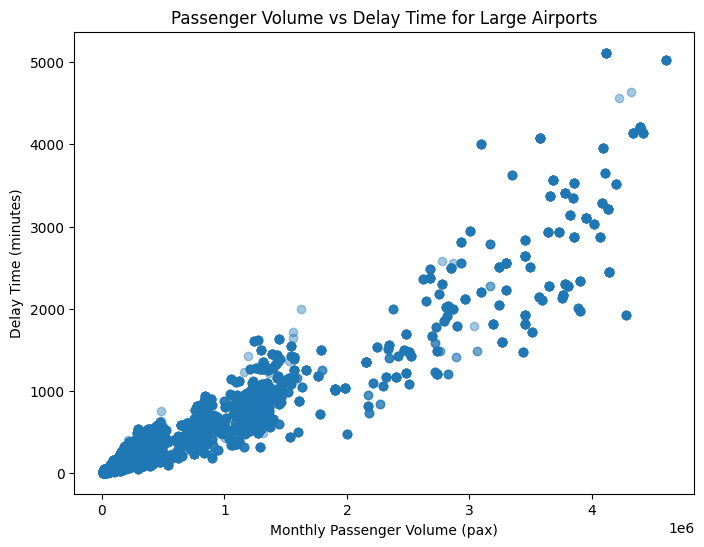

In [117]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_big["pax"], df_big["arr_del15"], alpha=0.4)
plt.xlabel("Monthly Passenger Volume (pax)")
plt.ylabel("Delay Time (minutes)")
plt.title("Passenger Volume vs Delay Time for Large Airports")
plt.show()


In [124]:
df_big["arr_flights"].isna().sum()

0

In [ ]:
import statsmodels.api as sm

X = sm.add_constant(df_big["pax"])
y = df_big["arr_del15"]

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2025
Date:                Sun, 07 Dec 2025   Prob (F-statistic):              0.653
Time:                        20:26:57   Log-Likelihood:                 16753.
No. Observations:               17142   AIC:                        -3.350e+04
Df Residuals:                   17140   BIC:                        -3.349e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2101      0.001    255.516      0.0